In [1]:
import os
import time
import random
import json
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [18, 10]
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from collections import defaultdict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def file_head(file, l=10):
    with open(file) as myfile:
        head_repres = [next(myfile) for x in range(l)]
    return(head_repres)

def execute(command):
    stream = os.popen(command)
    output = stream.read().strip()
    return(output)

def isNaN(num):
    return num != num

aminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
diamond_groups = ['K', 'C', 'G', 'H', 'I', 'M', 'F', 'Y', 'W', 'P', 'S']

# diamond groups: [KREDQN] [C] [G] [H] [ILV] [M] [F] [Y] [W] [P] [STA]
def get_diam(aa_seq):
    diam = ""
    for aa in aa_seq:
        diam += AA_DIAM[aa]        
    return(diam)


AA_FEAT = {'A':["sc_hydrophobic", "d_S"], 
           'R':["sc_poseleccharged", "d_K"], 
           'N':["sc_polaruncharged", "d_K"],
           'D':["sc_negeleccharged", "d_K"], 
           'C':["d_C"], 
           'Q':["sc_polaruncharged", "d_K"], 
           'E':["sc_negeleccharged", "d_K"], 
           'G':["d_G"],
           'H':["sc_poseleccharged", "d_H"], 
           'I':["sc_hydrophobic", "d_I"], 
           'L':["sc_hydrophobic", "d_I"], 
           'K':["sc_poseleccharged", "d_K"], 
           'M':["sc_hydrophobic", "d_M"],
           'F':["sc_hydrophobic", "d_F"], 
           'P':["d_P"], 
           'S':["sc_polaruncharged", "d_S"], 
           'T':["sc_polaruncharged", "d_S"], 
           'W':["sc_hydrophobic", "d_W"],
           'Y':["sc_hydrophobic", "d_Y"], 
           'V':["sc_hydrophobic", "d_I"]
          }

AA_DIAM = {'A' : "S", 'R': "K", 'N': "K", 'D': "K", 'C': "C", 'Q': "K", 'E': "K", 'G': "G", 'H': "H", 'I': "I", 'L': "I", 'K': "K", 'M': "M", 'F': "F", 'P': "P", 'S': "S", 'T': "S", 'W': "W", 'Y': "Y", 'V': "I"}

def all_feature_names():
    feat_list = ["sc_hydrophobic","sc_polaruncharged","sc_poseleccharged","sc_negeleccharged"]
    for aa in aminoacids:
        feat_list.append(aa)
    
    for d_aa in diamond_groups:
        feat_list.append("d_" + d_aa)
        
    for aa1 in aminoacids:
        for aa2 in aminoacids:
            feat_list.append(aa1+aa2)
    
    for d_aa1 in diamond_groups:
        for d_aa2 in diamond_groups:
            feat_list.append("d_" + d_aa1 + d_aa2)
            
    return feat_list

FEATURE_LIST = all_feature_names()

def features_of_seq(seq):
   
    feat = {}
    l = len(seq) 
    for f in FEATURE_LIST:
        feat[f] = 0
        
    for aa in seq :
        feat[aa] += 1
        for f in AA_FEAT[aa]:
            feat[f] += 1
    
    rangelen = l-1
    diam_seq = get_diam(seq)
    for i in range(0, rangelen):
        double = seq[i:i+2]
        feat[double] += 1
        diam_double = diam_seq[i:i+2]
        feat["d_" + diam_double] += 1
    return(feat)  

def kmer_features_of_protein(seq, k):
   
    feat = {}
    l = len(seq) 
    diam_seq = get_diam(seq)
    lk1 = l-k+1
    for f in FEATURE_LIST:
        feat[f] = [0] * (l-k+1)
    
    feat = pd.DataFrame(feat)
    
    for i in range(0,l):
        aa = seq[i]
        feat[aa][max(0,i-k+1):min(lk1,i+1)] += 1
        for f in AA_FEAT[aa]:
            feat[f][max(0,i-k+1):min(lk1,i+1)] += 1
    
    rangelen = l-1
    for i in range(0, rangelen):
        double = seq[i:i+2]
        feat[double][max(0,i-k+2):min(lk1,i+1)] += 1
        diam_double = diam_seq[i:i+2]
        feat["d_" + diam_double][max(0,i-k+2):min(lk1,i+1)] += 1
    return(feat)  


def balance_trainDS(X, y, random_state):
    wildtypeIDs = set([item[0] for item in X.index.str.split("_")])
    random.seed(random_state)
    size_smaller_group = y.value_counts().min()
    pos_IDs = set(y[y==1].index)
    neg_IDs = set(y[y==0].index)
    neg_IDs= random.sample(neg_IDs, size_smaller_group)
    pos_IDs= random.sample(pos_IDs, size_smaller_group)
    trainIDs = set(pos_IDs + neg_IDs)
    y_train = y[trainIDs]
    X_train = X.loc[trainIDs,]
    
    return(X_train, y_train)

def TFPN(ground_truth, prediction):
    TFPN = ""
    if ground_truth:
        if prediction:
            TFPN = "TP"
        else:
            TFPN = "FN"
    else:
        if prediction:
            TFPN = "FP"
        else:
            TFPN = "TN"
    return(TFPN)


In [2]:
vrc_reactivity = pd.read_table("VRC_reactivity.csv", sep=",", index_col = 0)

In [3]:
vrc_reactivity

,reactive samples,min 1 sample reactive,min 2 sample reactive,min 5 sample reactive
u_pep_id,,,,
AllergomeL_001_ATGGGGTTTATTACCAAGGCGATCCCTATCGTCCTCGCCGCCCTGAGTAC,0,0,0,0
AllergomeL_001_AACATGTCTTTAGGTGGTCCGCGCTCAGAGGCATCGAATCAGGCGGCCAA,5,1,1,1
AllergomeL_001_GCTGCGGGGAATGAAAATATGGACGCACAACATTCAAGTCCTGCAAGCGA,23,1,1,1
AllergomeL_001_GACGATGGTAAGGCGGACTTTTCTAACTATGGGGCAGTAGTGGACGTCTA,15,1,1,1
AllergomeL_001_GGCGGGAGTACTGACACGTTGTCTGGCACGTCCATGGCATCACCGCATGT,6,1,1,1
...,...,...,...,...
HumanLarma_003_GTCCGTAAAGCTAACGAGCGTTGTGAACGCTGTTGTGTTAGCATACAGGA,0,0,0,0
HumanLarma_003_AGCTTACATAAAGACTTTGCTTTTTACCTGGGCAAAGGCGGGTACTTTTC,3,1,1,0
HumanLarma_003_ATCAGTCTGCGCCTGCCGAATTTAGAAGCCCCGAGCCATATCAGTGGATC,0,0,0,0


In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20) 

In [7]:
tile_anno = pd.read_csv("phipseq_0068_Hits_foldchange_annotated.tsv", sep='\t', index_col = 0)
tile_anno = tile_anno.drop(tile_anno.columns[9:], axis = 1)
ebv = tile_anno[tile_anno["taxon_species"] == "Epstein-Barr virus"]
cmv = tile_anno[tile_anno["taxon_species"] == "Human cytomegalovirus"]
rhino = tile_anno[tile_anno["taxon_species"] == "Rhinovirus A"]
 

/home/anna/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,2,3,4,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
all_species = set(tile_anno["taxon_species"])
all_species = {x for x in all_species if x==x}

In [9]:
for s in all_species:
    if "hino" in s:
        print(s)

Human rhinovirus 1B
Human rhinovirus A39
Rhinovirus B
Human rhinovirus 14
Human rhinovirus A serotype 89
Human rhinovirus 1A
Human rhinovirus 3
Human rhinovirus 89
Human rhinovirus B70
Rhinovirus A
Human rhinovirus 16
Human rhinovirus 23
Human rhinovirus 2
rhinoceros


In [10]:
with open('tile_probabilities_cnn.json') as json_file:
    cnn_probabilities = json.load(json_file)
    
with open('tile_probabilities.json') as json_file:
    rf_probabilities = json.load(json_file)

In [11]:
vrc_reactivity["min 1 sample reactive"].value_counts()

0    385108
1    210984
Name: min 1 sample reactive, dtype: int64

In [12]:
ept_all_cnn = {}
ept_all_rf = {}
exampleKeys = random.sample(rf_probabilities.keys(),10000)

for k in exampleKeys:
    if k in rf_probabilities.keys():
        ept_all_rf[k] = rf_probabilities[k]
        ept_all_cnn[k] = cnn_probabilities[k]
    
#print(ept)

In [13]:
ebv_epi_probabilities_rf = {}
ebv_epi_probabilities_cnn = {}

for tile in ebv.index:
    ebv_epi_probabilities_rf[tile] = rf_probabilities[tile]
    ebv_epi_probabilities_cnn[tile] = cnn_probabilities[tile]
    
cmv_epi_probabilities_rf = {}
cmv_epi_probabilities_cnn = {}

for tile in cmv.index:
    if tile in rf_probabilities:
        cmv_epi_probabilities_rf[tile] = rf_probabilities[tile]
        cmv_epi_probabilities_cnn[tile] = cnn_probabilities[tile]
        
rhino_epi_probabilities_rf = {}
rhino_epi_probabilities_cnn = {}

for tile in rhino.index:
    rhino_epi_probabilities_rf[tile] = rf_probabilities[tile]
    rhino_epi_probabilities_cnn[tile] = cnn_probabilities[tile]

# not all predictions for cmv tiles available

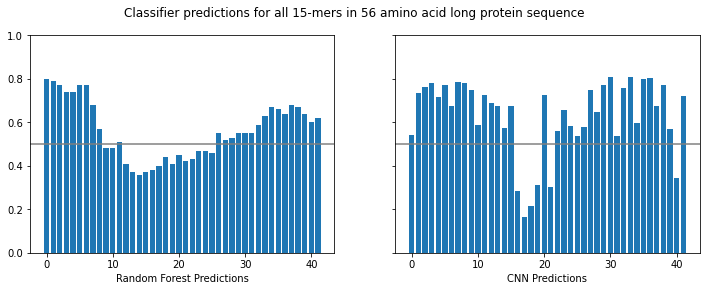

In [36]:
matplotlib.rcParams['figure.figsize'] = [12, 4]
k = "VirscanLar_001_ATGGATCACGACCTTGAACGCGGCCCACCTGGCCCTCGCCGCCCACCACG"
"MDHDLERGPPGPRRPPRGPPLSSSLGLALLLLLLALLFWLYIVMSNWAAGALLVLY"
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ep = ebv_epi_probabilities_rf
ax1.bar(np.arange(len(ep[k])),ep[k])
ax1.axhline(0.5, color="gray")
ax1.set(xlabel='Random Forest Predictions')
plt.ylim(0, 1)
vrc_reactive = vrc_reactivity.loc[k,"reactive samples"] > 1
contains_epitope = sum(np.array(ep[k]) > 0.5) > 0
tfpn_rf = TFPN(vrc_reactive, contains_epitope)

ep = ebv_epi_probabilities_cnn
ax2.bar(np.arange(len(ep[k])),ep[k])
ax2.axhline(0.5, color="gray")
ax2.set(xlabel="CNN Predictions")
#ax2.ylim(0, 1)
vrc_reactive = vrc_reactivity.loc[k,"reactive samples"] > 1
contains_epitope = sum(np.array(ep[k]) > 0.5) > 0
tfpn_cnn = TFPN(vrc_reactive, contains_epitope)

fig.suptitle(k + "\nReactive in 1078 VRC samples: " + str(vrc_reactive)+ ", Prediction RF:" + tfpn_rf + ", Prediction CNN:" + tfpn_cnn + "\n\n")
fig.suptitle("Classifier predictions for all 15-mers in 56 amino acid long protein sequence")

plt.savefig("CNNandRFprofile.png", format="png", bbox_inches="tight")
fig.show()

<BarContainer object of 42 artists>

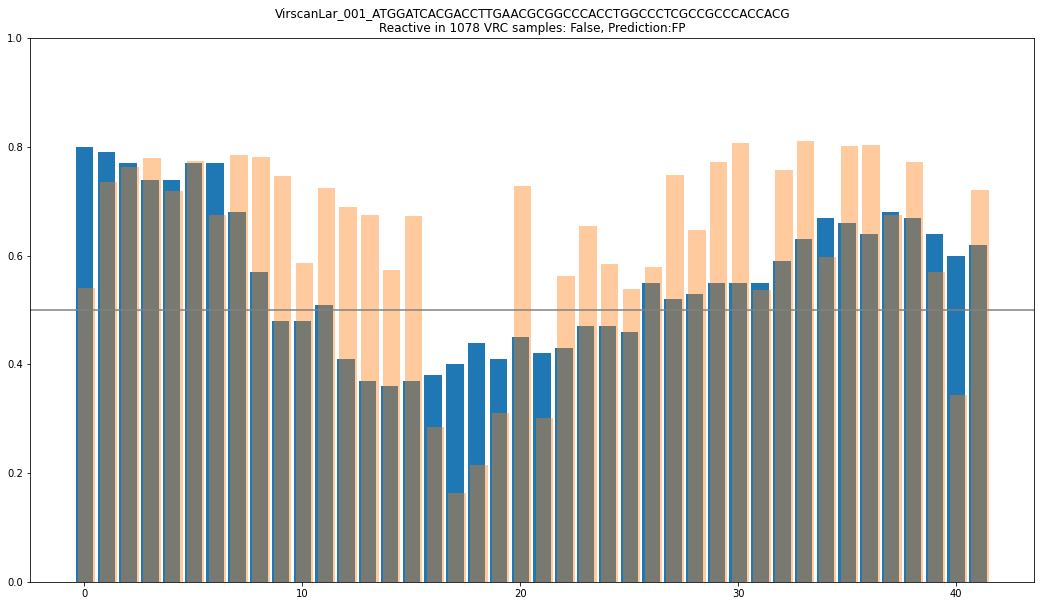

In [11]:
k = "VirscanLar_001_ATGGATCACGACCTTGAACGCGGCCCACCTGGCCCTCGCCGCCCACCACG"
ep = ebv_epi_probabilities_rf
plt.figure()
plt.bar(np.arange(len(ep[k])),ep[k])
plt.axhline(0.5, color="gray")
plt.ylim(0, 1)
vrc_reactive = vrc_reactivity.loc[k,"reactive samples"] > 1
contains_epitope = sum(np.array(ep[k]) > 0.5) > 0
tfpn = TFPN(vrc_reactive, contains_epitope)
plt.title(k + "\nReactive in 1078 VRC samples: " + str(vrc_reactive)+ ", Prediction:" + tfpn)

ep = ebv_epi_probabilities_cnn
plt.bar(np.arange(len(ep[k]))+.1,ep[k], alpha=0.4)

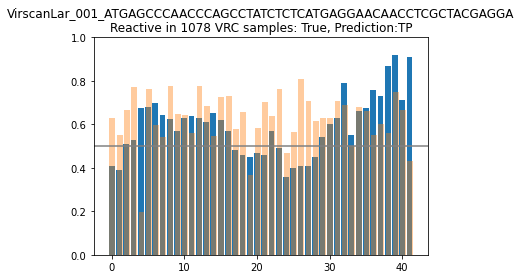

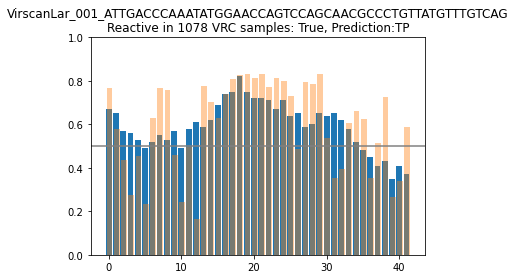

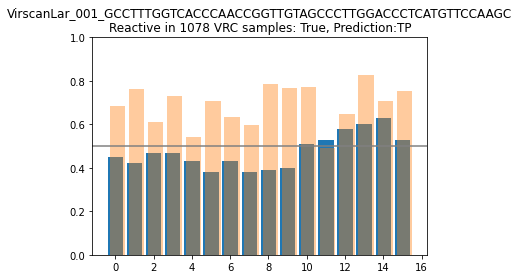

In [12]:
matplotlib.rcParams['figure.figsize'] = [6, 4]
exampleKeys = random.sample(ebv_epi_probabilities_rf.keys(),3)

for k in exampleKeys:
    ep = ebv_epi_probabilities_rf
    plt.figure()
    plt.bar(np.arange(len(ep[k])),ep[k])
    plt.axhline(0.5, color="gray")
    plt.ylim(0, 1)
    vrc_reactive = vrc_reactivity.loc[k,"reactive samples"] > 1
    contains_epitope = sum(np.array(ep[k]) > 0.5) > 0
    tfpn = TFPN(vrc_reactive, contains_epitope)
    plt.title(k + "\nReactive in 1078 VRC samples: " + str(vrc_reactive)+ ", Prediction:" + tfpn)

    ep = ebv_epi_probabilities_cnn
    plt.bar(np.arange(len(ep[k]))+.1,ep[k], alpha=0.4)

In [13]:
def scoring_tile(pred_vec_rf, pred_vec_cnn, version):
    v_cnn = np.array(pred_vec_cnn)
    v_rf = np.array(pred_vec_rf)
    
    if "_both" in version:
        if "var and mea" in version:
            return((1-np.var(v_cnn))*np.mean(v_rf))
        if "mean(>.5)" in version:
            pos_only_cnn = np.maximum(0,v_cnn-0.5)
            pos_only_rf = np.maximum(0,v_rf-0.5)
            no_epi_cnn = sum(pos_only_cnn > 0)
            no_epi_rf = sum(pos_only_rf > 0)
            if no_epi_cnn > 0 and no_epi_rf > 0:
                return(0.5 + 0.5*((sum(pos_only_cnn)/no_epi_cnn)+(sum(pos_only_rf)/no_epi_rf)))
            else:
                return(0.5*(np.mean(v_cnn)+np.mean(v_rf)))
        elif "mean" in version:
            return(np.mean(v_cnn)+np.mean(v_rf))
        elif "median" in version:
            return(np.median(v_cnn)+np.median(v_rf))
        elif "1-variance" in version:
            return(1-np.var(v_cnn)+(1-np.var(v_rf)))
        elif "90percentile" in version:
            return(np.percentile(v_rf,90)+np.percentile(v_cnn,90))    
        elif version==5:
            pos_only = np.maximum(0,v-0.5)
            windows = [pos_only[i:i+3] for i in range(len(v)-2)]
            winsums = [np.sum(w) for w in windows]
            if np.isnan(np.median(winsums)):
                return(np.max(pos_only))
            return(np.max(winsums))
        elif "max" in version:
            return(max(v_cnn)+max(v_rf))
        else:
            return (1)
    else:
        
        if "_rf" in version:
            v=v_rf
        elif "_cnn" in version:
            v= v_cnn
            
        if "mean(>.5)" in version:
            pos_only = np.maximum(0,v-0.5)
            no_epi = sum(pos_only > 0)
            if no_epi > 0:
                return(0.5 + (sum(pos_only)/no_epi))
            else:
                return(np.mean(v))
        elif "mean" in version:
            return(np.mean(v))
        elif "median" in version:
            return(np.median(v))
        elif "1-variance" in version:
            return(1-np.var(v))
        elif "90percentile" in version:
            return(np.percentile(v,90))
        elif "max" in version:
            return(max(v))
        else:
            return(1)
     

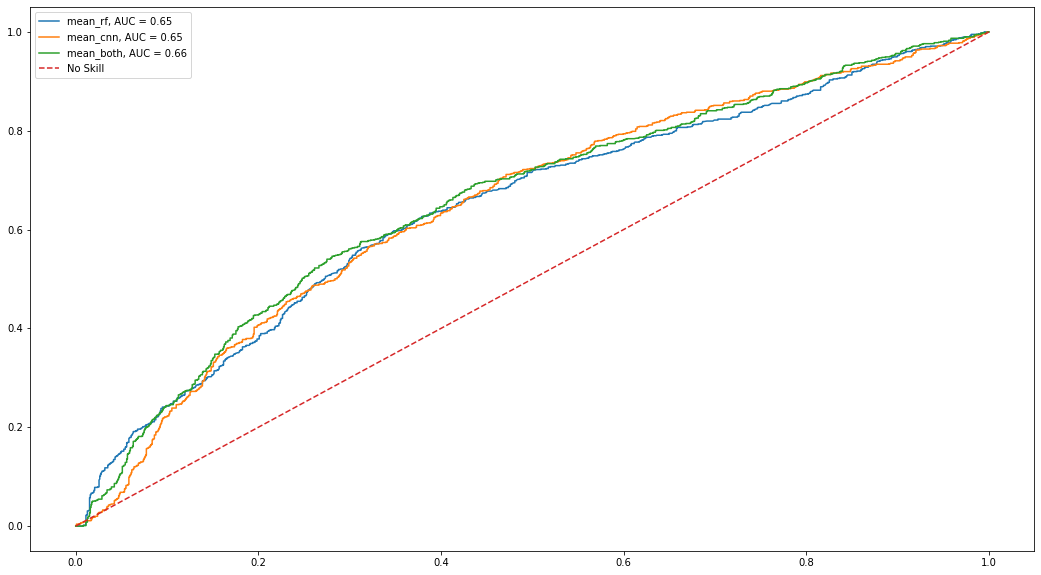

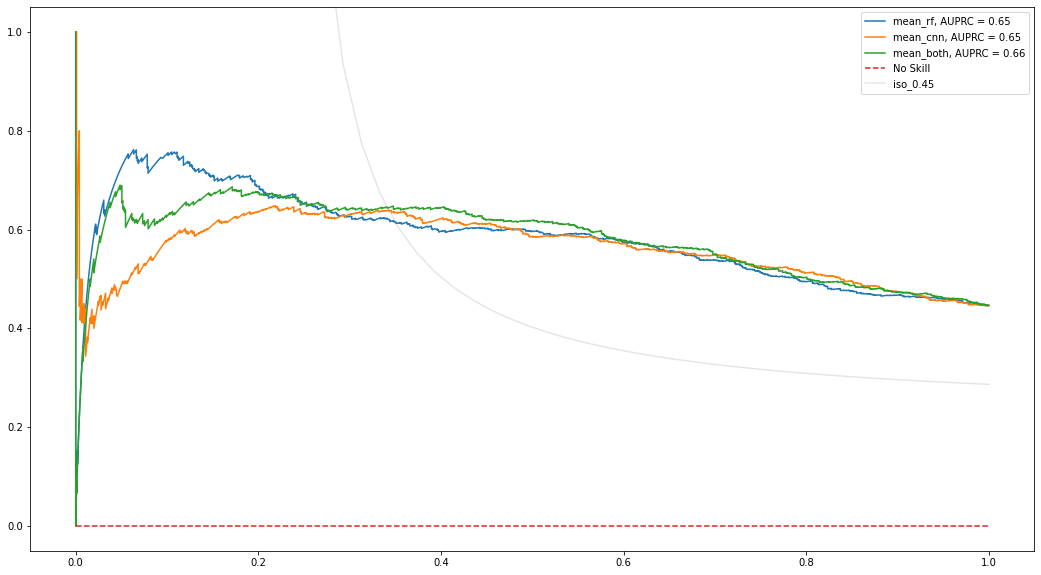

In [18]:
matplotlib.rcParams['figure.figsize'] = [18, 10]

cutoff_minsamplesVRC = 2
ept = (ebv_epi_probabilities_rf, ebv_epi_probabilities_cnn) 
#ept = (cmv_epi_probabilities_rf, cmv_epi_probabilities_cnn)
#ept = (rhino_epi_probabilities_rf, rhino_epi_probabilities_cnn) 
#ept = (ept_all_rf, ept_all_cnn)

comp_df_t = pd.DataFrame({"VRC reactive" : [vrc_reactivity.loc[k,"reactive samples"] >= cutoff_minsamplesVRC for k in ept[0].keys()]})
comp_df_t["VRC reactive"] = comp_df_t["VRC reactive"].astype(int)
fig_roc, ax_roc = plt.subplots()
fig_pr, ax_pr = plt.subplots()
for predictor in ["rf","cnn","both"]:
    for function in ["mean"]:#, "var and mea", "max","median","1-variance","90percentile","mean(>.5)"]:
        scoring_func = function + "_" + predictor
        score_label = "tile_score_"+str(scoring_func)
        comp_df_t[score_label] = [scoring_tile(ept[0][k],ept[1][k],scoring_func) for k in ept[0].keys()]
        fpr, tpr, _ = roc_curve(comp_df_t["VRC reactive"], comp_df_t[score_label])
        auc_score = round(metrics.roc_auc_score(comp_df_t["VRC reactive"], comp_df_t[score_label]) ,2)       
        auprc_score = round(metrics.average_precision_score(comp_df_t["VRC reactive"], comp_df_t[score_label]) ,2)       
        precision, recall, _ = precision_recall_curve(comp_df_t["VRC reactive"], comp_df_t[score_label])
        ax_roc.plot(fpr, tpr, label=scoring_func + ", AUC = " + str(auc_score))
        ax_pr.plot(recall, precision, label=scoring_func + ", AUPRC = " + str(auc_score))

ax_roc.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
ax_pr.plot([0, 1], [0, 0], linestyle='--', label='No Skill')
f_score = comp_df_t["VRC reactive"].value_counts()[1]/len(comp_df_t["VRC reactive"])
x = np.linspace(0.01, 1)
yf = f_score * x / (2 * x - f_score)
ax_pr.plot(x[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2, label = "iso_"+str(round(f_score,2)))
plt.ylim([-0.05, 1.05])
ax_roc.legend()
ax_pr.legend()
#plt.show()
fig_roc.savefig('ebv_existing_tiles_roc.pdf')  

In [15]:
comp_df_t["VRC reactive"].value_counts()

0    1254
1    1009
Name: VRC reactive, dtype: int64